# 📘 Data Merging & Cleaning – Yousra Descriptive Stats Notebook

This notebook loads the original project datasets (sales, weather, kiwo event),  
cleans and standardizes the date format, merges them using a full outer join,  
and performs descriptive statistics, missing value inspection, and prepares the  
data for further feature engineering and modeling.

The goal is to:
1. Combine **all available data** on matching dates  
2. Perform a clear descriptive exploration  
3. Detect and handle missing values  
4. Produce a clean dataset ready for analysis  


In [1]:
import pandas as pd
import numpy as np

# Load data from your project folder
df_kiwo = pd.read_csv("data/kiwo.csv")
df_weather = pd.read_csv("data/wetter.csv")
df_umsatz = pd.read_csv("data/umsatzdaten_gekuerzt.csv")

df_kiwo.head(), df_weather.head(), df_umsatz.head()
#print number of rows for each dataframe
print(f"Kiwo Data Rows: {len(df_kiwo)}")
print(f"Weather Data Rows: {len(df_weather)}")
print(f"Umsatz Data Rows: {len(df_umsatz)}")

Kiwo Data Rows: 72
Weather Data Rows: 2601
Umsatz Data Rows: 9334


In [2]:
# Convert 'Datum' to proper datetime format and drop invalid rows
for df in (df_kiwo, df_weather, df_umsatz):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce").dt.normalize()
    df.dropna(subset=["Datum"], inplace=True)

    # Drop duplicate date columns if exist
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)

df_kiwo.info(), df_weather.info(), df_umsatz.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datum        72 non-null     datetime64[ns]
 1   KielerWoche  72 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                2601 non-null   datetime64[ns]
 1   Bewoelkung           2591 non-null   float64       
 2   Temperatur           2601 non-null   float64       
 3   Windgeschwindigkeit  2601 non-null   int64         
 4   Wettercode           1932 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 101.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 

(None, None, None)

In [3]:
# Adding suffixes helps avoid confusion during merging

df_kiwo = df_kiwo.add_suffix("_kiwo")
df_kiwo.rename(columns={"Datum_kiwo": "Datum"}, inplace=True)

df_weather = df_weather.add_suffix("_weather")
df_weather.rename(columns={"Datum_weather": "Datum"}, inplace=True)


df_umsatz = df_umsatz.add_suffix("_umsatz")
df_umsatz.rename(columns={"Datum_umsatz": "Datum"}, inplace=True)

df_umsatz["umsatz_rolling7"] = (
    df_umsatz["Umsatz_umsatz"].rolling(window=7, min_periods=1).mean()
)


In [5]:
merged_df = (
    df_kiwo
    .merge(df_weather, on="Datum", how="outer")
    .merge(df_umsatz, on="Datum", how="outer")
)

merged_df.shape
merged_df.head()


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7
0,2012-01-01,NaN,8.0,9.8250,14.0,58.0,NaN,NaN,NaN,NaN
1,2012-01-02,NaN,7.0,7.4375,12.0,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,8.0,5.5375,18.0,63.0,NaN,NaN,NaN,NaN
3,2012-01-04,NaN,4.0,5.6875,19.0,80.0,NaN,NaN,NaN,NaN
4,2012-01-05,NaN,6.0,5.3000,23.0,80.0,NaN,NaN,NaN,NaN


In [6]:
# Numeric summary
merged_df.describe()

# For all columns (including categorical)
merged_df.describe(include="all")


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7
count,10119,250.0,10048.000000,10103.000000,10103.000000,7581.000000,9.334000e+03,9334.000000,9334.000000,9334.000000
mean,2016-01-04 09:37:20.260895488,1.0,4.748507,12.014560,11.026527,37.072022,1.559311e+06,3.088172,206.749044,206.776906
min,2012-01-01 00:00:00,1.0,0.000000,-10.250000,3.000000,0.000000,1.307011e+06,1.000000,7.051201,28.664341
25%,2014-08-31 00:00:00,1.0,3.000000,6.250000,8.000000,10.000000,1.410123e+06,2.000000,96.897441,101.285593
50%,2016-01-06 00:00:00,1.0,6.000000,11.625000,10.000000,28.000000,1.601102e+06,3.000000,161.900831,154.098561
75%,2017-05-26 00:00:00,1.0,7.000000,17.875000,13.000000,61.000000,1.704223e+06,4.000000,280.644663,290.012266
max,2019-08-01 00:00:00,1.0,8.000000,32.671428,35.000000,95.000000,1.807315e+06,6.000000,1879.461831,746.064991
std,NaN,0.0,2.628285,7.212466,4.131774,27.207627,1.512503e+05,1.489002,144.545189,131.740326


In [7]:
missing_count = merged_df.isna().sum()
missing_percent = (merged_df.isna().sum() / len(merged_df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing %": missing_percent
})

missing_df


,Missing Count,Missing %
Datum,0,0.000000
KielerWoche_kiwo,9869,97.529400
Bewoelkung_weather,71,0.701650
Temperatur_weather,16,0.158118
Windgeschwindigkeit_weather,16,0.158118
Wettercode_weather,2538,25.081530
id_umsatz,785,7.757684
Warengruppe_umsatz,785,7.757684
Umsatz_umsatz,785,7.757684
umsatz_rolling7,785,7.757684


### ✔️ Missing Value Strategy

**Umsatz (Sales):**
- Missing values mean the day has **no sales** or is **outside the bakery event period**.
- These rows should be **removed**, not imputed.

**Weather Variables:**
- Weather data may be missing because not all dates have weather records.
- Fill missing values using interpolation (numerical)  
  and assign -1 for Wettercode to indicate “unknown weather”.

**Kiwo Event Flag:**
- If missing → fill with 0 (day outside event).


In [8]:
clean_df = merged_df.copy()

# Remove rows where sales are missing
clean_df = clean_df.dropna(subset=["Umsatz_umsatz"])

# Fill missing Wettercode with category -1
if "Wettercode_weather" in clean_df.columns:
    clean_df["Wettercode_weather"] = clean_df["Wettercode_weather"].fillna(-1)

# Interpolate numerical weather values
for col in clean_df.columns:
    if ("_weather" in col) and (clean_df[col].dtype in ["float64", "int64"]):
        clean_df[col] = clean_df[col].interpolate()

clean_df.isna().sum()


Datum                             0
KielerWoche_kiwo               9111
Bewoelkung_weather                0
Temperatur_weather                0
Windgeschwindigkeit_weather       0
Wettercode_weather                0
id_umsatz                         0
Warengruppe_umsatz                0
Umsatz_umsatz                     0
umsatz_rolling7                   0
dtype: int64

In [10]:
clean_df["KielerWoche_kiwo"] = clean_df["KielerWoche_kiwo"].fillna(0)


In [11]:
clean_df.isna().sum()


Datum                          0
KielerWoche_kiwo               0
Bewoelkung_weather             0
Temperatur_weather             0
Windgeschwindigkeit_weather    0
Wettercode_weather             0
id_umsatz                      0
Warengruppe_umsatz             0
Umsatz_umsatz                  0
umsatz_rolling7                0
dtype: int64

In [12]:
#drop wettercode_weather column
df_no_weather_code = clean_df.drop(columns=["Wettercode_weather"])
df_no_weather_code.sample(5)


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7
6944,2017-01-16,0.0,0.0,0.250,9.0,1701161.0,1.0,88.902128,89.619225
2982,2014-11-25,0.0,0.0,6.875,4.0,1411252.0,2.0,296.604332,374.357207
6429,2016-10-12,0.0,7.0,9.750,18.0,1610122.0,2.0,344.070542,384.694215
8212,2017-09-29,0.0,2.0,19.100,6.0,1709291.0,1.0,112.985220,134.071162
8316,2017-10-19,0.0,6.0,14.850,9.0,1710195.0,5.0,248.139879,254.161161


## Adding extra columns

In [13]:
df_no_weather_code['Datum'] = pd.to_datetime(df_no_weather_code['Datum'], errors='coerce').dt.normalize()
n_invalid = df_no_weather_code['Datum'].isna().sum()
if n_invalid > 0:
    print(f"Warning: {n_invalid} rows have invalid 'Datum' and will have NaT in day columns. Sample:")
    display(df_no_weather_code[df_no_weather_code['Datum'].isna()].head())

# Create integer and name columns for day of week
df_no_weather_code['day_of_week'] = df_no_weather_code['Datum'].dt.weekday  # Monday=0 .. Sunday=6
df_no_weather_code['day'] = df_no_weather_code['Datum'].dt.day_name()

# Optional: make 'day' categorical ordered Monday..Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_no_weather_code['day'] = pd.Categorical(df_no_weather_code['day'], categories=ordered_days, ordered=True)

print("\nCounts per weekday:")
print(df_no_weather_code['day'].value_counts().sort_index())
df_no_weather_code.sample(5)


Counts per weekday:
day
Monday       1324
Tuesday      1345
Wednesday    1342
Thursday     1334
Friday       1311
Saturday     1336
Sunday       1342
Name: count, dtype: int64


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,day_of_week,day
834,2013-09-28,0.0,0.0,13.1000,8.0,1309284.0,4.0,98.437577,96.349381,5,Saturday
1353,2014-01-02,0.0,7.0,6.2500,9.0,1401023.0,3.0,142.307971,160.553726,3,Thursday
1045,2013-11-07,0.0,6.0,9.5000,10.0,1311073.0,3.0,122.745431,132.967744,3,Thursday
5666,2016-05-08,0.0,0.0,21.3750,17.0,1605085.0,5.0,262.509023,255.613189,6,Sunday
8901,2018-02-06,0.0,1.0,-0.8625,5.0,1802064.0,4.0,108.184958,90.188907,1,Tuesday


### Adding more weather data from meteo archive api

In [14]:
import requests
from datetime import datetime, date, timedelta
import time
from typing import Union, Iterable, Dict, List
import pandas as pd
import numpy as np

# Simple in-memory cache for API responses
try:
    _OPEN_METEO_CACHE
except NameError:
    _OPEN_METEO_CACHE: Dict[str, Dict[str, float]] = {}

def _iso_date(d: Union[str, date, datetime]) -> str:
    if isinstance(d, str):
        return datetime.fromisoformat(d).date().isoformat()
    if isinstance(d, datetime):
        return d.date().isoformat()
    return d.isoformat()

def fetch_open_meteo_daily_range(
    start_date: Union[str, date, datetime],
    end_date: Union[str, date, datetime],
    latitude: float = 54.3233,
    longitude: float = 10.1228,
    timezone: str = "Europe/Berlin",
    daily_vars: List[str] = None,
    max_retries: int = 3,
    timeout: float = 15.0,
    use_cache: bool = True
) -> pd.DataFrame:
    """
    Fetch daily historical variables from Open-Meteo archive API for a given inclusive date range.
    By default uses Kiel coordinates (lat=54.3233, lon=10.1228).
    daily_vars example: ['precipitation_hours', 'sunshine_duration', 'rain_sum']
    Returns a pandas.DataFrame indexed by date (datetime.date) with columns named after daily_vars.
    """
    if daily_vars is None:
        daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum']

    start_iso = _iso_date(start_date)
    end_iso = _iso_date(end_date)
    start_dt = datetime.fromisoformat(start_iso).date()
    end_dt = datetime.fromisoformat(end_iso).date()
    if end_dt < start_dt:
        raise ValueError("end_date must be >= start_date")

    # Build cache key based on parameters and requested range
    key = f"{latitude:.6f}_{longitude:.6f}_{start_iso}_{end_iso}_{','.join(daily_vars)}_{timezone}"
    if use_cache and key in _OPEN_METEO_CACHE:
        df = _OPEN_METEO_CACHE[key].copy()
        return df

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_iso,
        "end_date": end_iso,
        "daily": ",".join(daily_vars),
        "timezone": timezone
    }

    last_exc = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(base_url, params=params, timeout=timeout)
            r.raise_for_status()
            data = r.json()
            daily = data.get("daily", {})
            times = daily.get("time", []) or []
            if not times:
                raise ValueError("No 'time' in API response daily block.")
            results = {"date": pd.to_datetime(times).date}
            for v in daily_vars:
                vals = daily.get(v, None)
                if vals is None:
                    # If a requested variable is missing, fill with NaN
                    results[v] = [np.nan] * len(times)
                else:
                    # Convert to numeric (floats), keep NaN if parsing fails
                    results[v] = [float(x) if x is not None else np.nan for x in vals]
            df = pd.DataFrame(results, index=pd.to_datetime(times).date)
            df.index.name = "date"
            df = df[[v for v in daily_vars]]  # ensure column order
            if use_cache:
                _OPEN_METEO_CACHE[key] = df.copy()
            return df
        except Exception as e:
            last_exc = e
            if attempt < max_retries:
                time.sleep(0.5 * attempt)
                continue
            raise RuntimeError(f"Failed fetching Open-Meteo archive: {e}") from e


In [15]:
min_date = df_no_weather_code['Datum'].min()
max_date = df_no_weather_code['Datum'].max()
##min_date = "2013-07-01"
##max_date = "2014-07-30"
print (f"Fetching weather data from {min_date} to {max_date}...")
lat_kiel, lon_kiel = 54.3233, 10.1228
daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum','temperature_2m_mean']
df_extra_weather = fetch_open_meteo_daily_range(min_date, max_date, latitude=lat_kiel, longitude=lon_kiel, daily_vars=daily_vars)
# print columns of df_extended_weather


Fetching weather data from 2013-07-01 00:00:00 to 2018-07-31 00:00:00...


In [16]:
df_extra_weather['sunshine_hours'] = df_extra_weather['sunshine_duration'] / 3600.0
#df_extended_weather.head()

# print row count for df_extended_weather and df_no_weather_code
print(f"Extended Weather Data Rows: {len(df_extra_weather)}")
print(f"Sales Data Rows: {len(df_no_weather_code)}")


Extended Weather Data Rows: 1857
Sales Data Rows: 9334


### Extended Data Frames
Its with extra weather data from open meteo api: df_merged_extended_weather
with rolling 7 day average as well for umsatz

In [ ]:
df_extra_weather.index = pd.to_datetime(df_extra_weather.index)
df_merged_extended_weather = df_no_weather_code.merge(
    df_extra_weather,
    left_on='Datum',
    right_index=True,
    how='left'
)

print(f"Merged DataFrame Rows: {len(df_merged_extended_weather)}")
print(f"Merged DataFrame Shape: {df_merged_extended_weather.shape}")

df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["id_umsatz"])
df_merged_extended_weather["id_umsatz"] = df_merged_extended_weather["id_umsatz"].astype("int64")
df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["KielerWoche_kiwo"])
df_merged_extended_weather["KielerWoche_kiwo"] = df_merged_extended_weather["KielerWoche_kiwo"].astype("int64")

df_merged_extended_weather.head()

Merged DataFrame Rows: 9334
Merged DataFrame Shape: (9334, 16)


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,day_of_week,day,precipitation_hours,sunshine_duration,rain_sum,temperature_2m_mean,sunshine_hours
394,2013-07-01,0.0,6.0,17.8375,15.0,1307011.0,1.0,148.828353,148.828353,0,Monday,7.0,31025.67,1.0,15.6,8.618242
395,2013-07-01,0.0,6.0,17.8375,15.0,1307012.0,2.0,535.856285,221.786925,0,Monday,7.0,31025.67,1.0,15.6,8.618242
396,2013-07-01,0.0,6.0,17.8375,15.0,1307013.0,3.0,201.198426,592.534505,0,Monday,7.0,31025.67,1.0,15.6,8.618242
397,2013-07-01,0.0,6.0,17.8375,15.0,1307014.0,4.0,65.890169,311.369828,0,Monday,7.0,31025.67,1.0,15.6,8.618242
398,2013-07-01,0.0,6.0,17.8375,15.0,1307015.0,5.0,317.475875,109.314600,0,Monday,7.0,31025.67,1.0,15.6,8.618242


# Testing Regression

,Umsatz_umsatz,umsatz_rolling7,KielerWoche_kiwo,Bewoelkung_weather,rain_sum,sunshine_hours,Temperatur_weather,Windgeschwindigkeit_weather,precipitation_hours,day_of_week
Umsatz_umsatz,1.000000,0.905683,0.058244,-0.089410,-0.006203,0.172404,0.222754,0.014656,-0.035543,0.136199
umsatz_rolling7,0.905683,1.000000,0.032139,-0.086245,0.004748,0.182786,0.243818,0.013879,-0.024387,-0.001206
KielerWoche_kiwo,0.058244,0.032139,1.000000,0.011505,0.023145,0.088911,0.138329,0.020482,0.026237,0.042733
Bewoelkung_weather,-0.089410,-0.086245,0.011505,1.000000,0.272869,-0.650125,-0.391204,0.040599,0.427817,-0.004879
rain_sum,-0.006203,0.004748,0.023145,0.272869,1.000000,-0.266330,0.029935,0.144634,0.778271,0.012229
sunshine_hours,0.172404,0.182786,0.088911,-0.650125,-0.266330,1.000000,0.625493,0.075587,-0.376662,-0.017579
Temperatur_weather,0.222754,0.243818,0.138329,-0.391204,0.029935,0.625493,1.000000,0.004367,-0.113850,0.004351
Windgeschwindigkeit_weather,0.014656,0.013879,0.020482,0.040599,0.144634,0.075587,0.004367,1.000000,0.191661,-0.005762
precipitation_hours,-0.035543,-0.024387,0.026237,0.427817,0.778271,-0.376662,-0.113850,0.191661,1.000000,-0.007771
day_of_week,0.136199,-0.001206,0.042733,-0.004879,0.012229,-0.017579,0.004351,-0.005762,-0.007771,1.000000


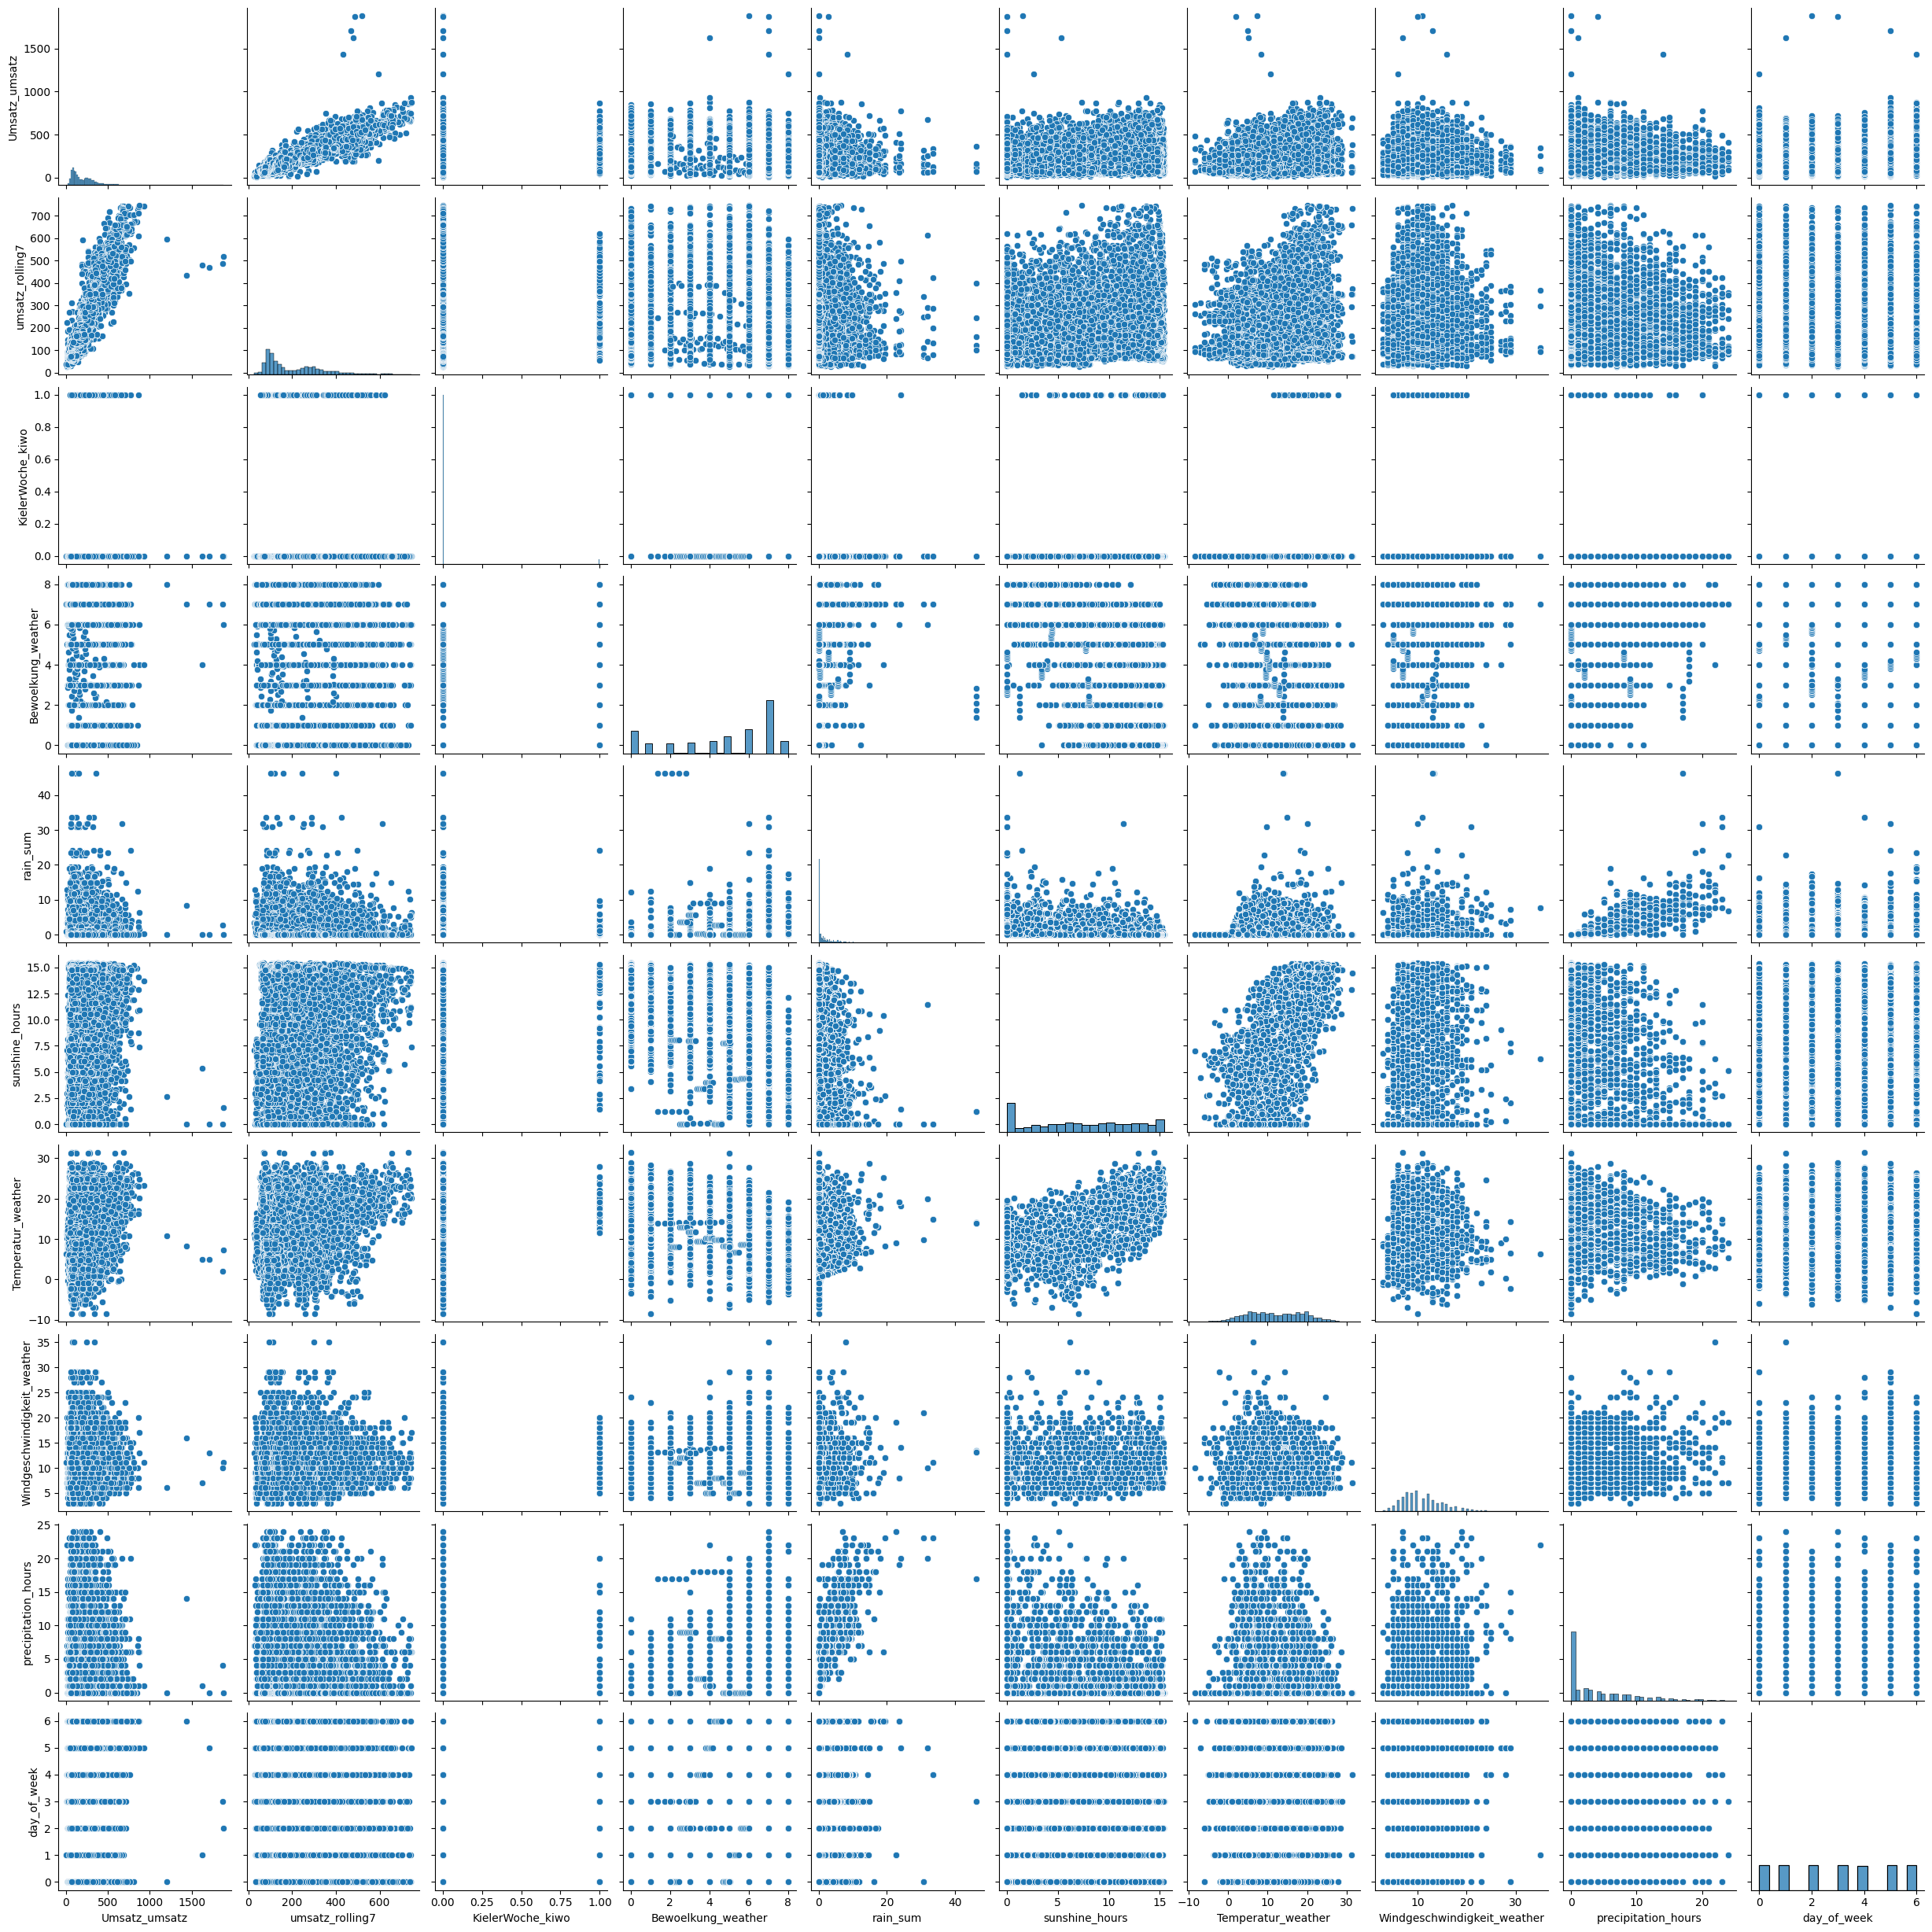

In [24]:
import scipy.stats as stats
import seaborn as sns
# Testing Regression
reg_cols=['Umsatz_umsatz','umsatz_rolling7','KielerWoche_kiwo','Bewoelkung_weather', 'rain_sum', 'sunshine_hours','Temperatur_weather','Windgeschwindigkeit_weather','precipitation_hours','day_of_week']
sns.pairplot(df_merged_extended_weather[reg_cols].dropna())
df_merged_extended_weather[reg_cols].corr()

In [25]:
import statsmodels.formula.api as smf

# Example regression formula (adjust as needed)
formula = "Umsatz_umsatz ~  Temperatur_weather + umsatz_rolling7 + C(Warengruppe_umsatz)"

# Drop rows with missing values in the regression columns
regression_df = df_merged_extended_weather.dropna(subset=[
    "Umsatz_umsatz", "Bewoelkung_weather", "rain_sum", "sunshine_hours",
    "Temperatur_weather", "Windgeschwindigkeit_weather", "precipitation_hours", "day_of_week"
])

# Fit the model
model = smf.ols(formula, data=regression_df).fit()

# Show summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Umsatz_umsatz   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     6098.
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:24:40   Log-Likelihood:                -51646.
No. Observations:                9334   AIC:                         1.033e+05
Df Residuals:                    9326   BIC:                         1.034e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.8930      1.974      1.972      0.049       0.023       7.763
C(Warengruppe_umsatz)[T.2.0]    15.8557      3.745      4.233      0.000       8.514      23.198
C(Warengruppe_umsatz)[T.3.0]     1.7413      2.084      0.836      0.403      -2.344       5.826
C(Warengruppe_umsatz)[T.4.0]    -2.2787      2.080     -1.095      0.273      -6.356       1.799
C(Warengruppe_umsatz)[T.5.0]     8.6704      2.672      3.245      0.001       3.433      13.908
C(Warengruppe_umsatz)[T.6.0]    -4.0953      3.906     -1.049      0.294     -11.752       3.561
Temperatur_weather               0.2205      0.099      2.216      0.027       0.025       0.415
umsatz_rolling7                  0.9462      0.011     84.040      0.000       0.924       0.968
==============================================================================
Omnibus:                    10464.251   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3884975.556
Skew:                           5.239   Prob(JB):                         0.00
Kurtosis:                     102.395   Cond. No.                     1.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""